# Physics Informed Neural Networks

## Introduction

Definition
PINNs are Neural Networks used to learn a generic function $f$ that combine:

Data fitting (like standard neural networks) - accounting for observation data ${ x_i }_{i=1}^N$
Physics constraints - guided by a regularization term that encourages $f$ to be the solution of a Partial Differential Equation (PDE)


Key Concept
The total loss function is: $$\mathcal{L}{\text{tot}} = \mathcal{L}{\text{data}} + \mathcal{L}_{\text{PDE}}$$

Where:

$\mathcal{L}_{\text{data}}$ = traditional data fitting loss (MSE between predictions and observations)
$\mathcal{L}_{\text{PDE}}$ = physics-informed loss that penalizes violations of the governing PDE
Advantages over Traditional Methods
vs. Traditional Neural Networks:

✅ $\mathcal{L}_{\text{PDE}}$ regularizes the model, limiting overfitting and improving generalization
✅ Provides physically meaningful predictions even with sparse data
vs. Traditional PDE Solvers:

✅ More scalable and handle big data better
✅ Can easily integrate external data sources (e.g., sensor data)
✅ Avoid computational expense of traditional numerical methods
How They Work
Neural network learns to approximate the solution function $f$
Automatic differentiation computes derivatives needed for the PDE
Training minimizes both data error AND PDE violation
Boundary/initial conditions ensure unique solutions

### Traditional PDE solvers

- Simple problems can be solved analytically.

- E.g., consider the velocity:

$$v(t) = \frac{d x}{d t} = \lim_{h \rightarrow 0} \frac{x(t+h) - x(t)}{h}$$

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/simple_pde.png?raw=1" style="width: 40%; display: block; margin: auto;">

- Solution:

$$
v(t) =
\begin{cases}
3/2 & \text{if}\; t \in \{ 0, 2 \} \\
0 & \text{if}\; t \in \{ 2, 4 \} \\
-1/3 & \text{if}\; t \in \{ 4, 7 \}
\end{cases}
$$

In [57]:
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use("dark_background")

In [58]:
plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor': 'black',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})

Let's start by creating a simple neural network in <a href="https://pytorch.org"><b>PyTorch</b></a>.

In [59]:
# Simple neural network for regression
class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out

Then, we use the NN to make predictions: $\hat{y}_i = \rm{NN}(x_i)$.
- Create a small dataset $\{x_i, y_i\}_{i=1, \dots 5}$.

In [60]:
# Define dataset
x_train = torch.tensor([[1.1437e-04],
        [1.4676e-01],
        [3.0233e-01],
        [4.1702e-01],
        [7.2032e-01]], dtype=torch.float32)
y_train = torch.tensor([[1.0000],
        [1.0141],
        [1.0456],
        [1.0753],
        [1.1565]], dtype=torch.float32)

- Train the NN by minimizing $\rm{MSE}(\boldsymbol{y}, \boldsymbol{\hat{y}})$.

In [61]:
# Initialize the model
model = simple_NN()

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(1000):
    # Compute prediction error
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.313917
epoch: 200, loss: 0.000135
epoch: 400, loss: 0.000034
epoch: 600, loss: 0.000009
epoch: 800, loss: 0.000007


After training is done, we can evaluate the model on all data points in the domain.

In [62]:
# Define the domain where to evaluate the function
domain = [0.0, 1.5]
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = model(x_eval)

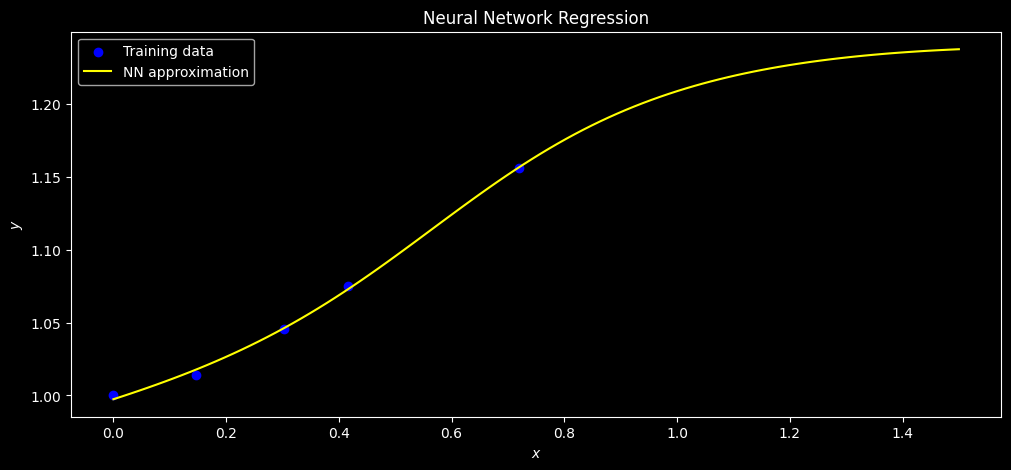

In [63]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Training data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="yellow")
ax.set(title="Neural Network Regression", xlabel="$x$", ylabel="$y$")
ax.legend()

- The NN does a good job in fitting the data samples.
- However, it has no information on what function should learn when $x>0.8$.

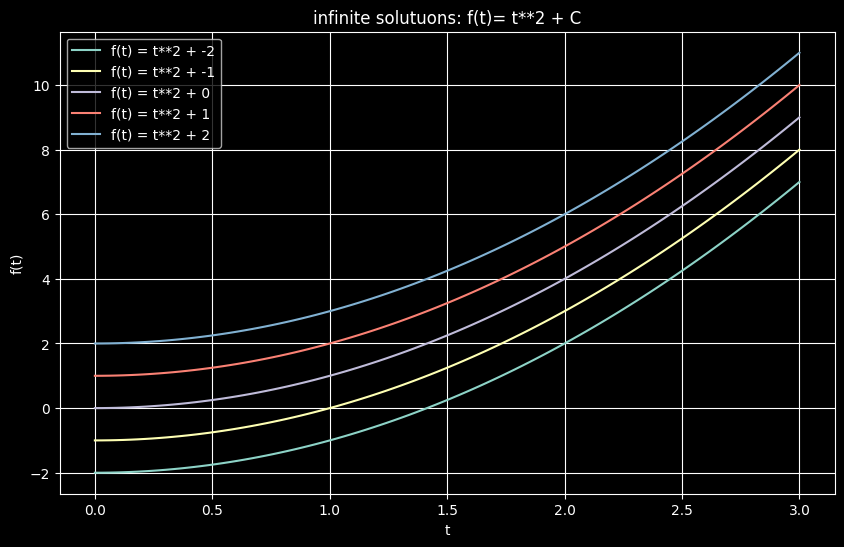

In [85]:
# Digressing: differential equation with varying constants

## consider a simple equation: df/dt = 2t
# solutions are: f(t) = t**2 + C

t= np.linspace(0, 3, 100)

c_values = [-2, -1, 0, 1, 2]
plt.figure(figsize= (10,6))

for c in c_values:
    f= t**2 + c
    plt.plot(t, f, label= f"f(t) = t**2 + {c}") # can add if statements for consistent +/- signs

plt.xlabel('t')
plt.ylabel("f(t)")
plt.title("infinite solutuons: f(t)= t**2 + C")
plt.legend()
plt.grid(True)
plt.show()

## Physics Informed NNs

- Use PDEs to adjust the NN output.
- Train the model with an additional loss that penalizes the violation of the PDE.

$$ \mathcal{L}_{\text{tot}} =  \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{PDE}}$$


<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/neural_net_pde.png?raw=1" style="width: 50%; display: block; margin: auto;">

### Example I: population growth

Logistic equation for modeling the population growth:

$$ \frac{d f(t)}{d t} = Rt(1-t)$$

- $f(t)$ is the population growth over time $t$.
- $R$ is the max growth rate.



- In general, there are *infinite* solutions satisfying the Logistic equation.
- To identify a unique solution, a boundary condition must be imposed, e.g., at $t=0$:

$$f(t=0)=1$$

In [65]:
R = 1.0
ft0 = 1.0

- Use the NN to model $f(t)$, i.e., $$f(t) = \rm{NN}(t)$$
- We can easily compute the derivative $\frac{d\rm{NN}(t)}{dt}$ thanks to automatic differentiation provided by deep learning libraries.


In [ ]:
def df(f: simple_NN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features
    using PyTorch autograd engine"""

    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

- We want our NN to satisfy the following equation:

$$ \frac{d\rm{NN}(t)}{dt} - Rt(1-t) = 0 $$

- To do that, we add the following physics-informed regularization term to the loss:

$$ \mathcal{L}_\text{PDE} = \frac{1}{N} \sum_{i=1}^N \left( \frac{d\text{NN}}{dt} \bigg\rvert_{t_i} - R t_i (1-t_i) \right)^2 $$

where $t_i$ are **collocation points**, i.e., a set of points from the domain where we evaluate the differential equation.

- First, we generate $10$ evenly distributed collocation points.

In [67]:
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

- Only minimizing $\mathcal{L}_\text{PDE}$ does not ensure a unique solution.
- We must include the boundary condition by adding the following loss:

$$ \mathcal{L}_\text{BC} = \left( \text{NN}(t_0) - 1 \right)^2 $$

- This lets the NN converge to the desired solution among the infinite possible ones.

The final loss is given by:

$$ \mathcal{L}_\text{PDE} + \mathcal{L}_\text{BC} + \mathcal{L}_\text{data} $$

In [ ]:
# Wrap everything into a function
def compute_loss(nn: simple_NN,
                 t: torch.Tensor = None,
                 x: torch.Tensor = None,
                 y: torch.Tensor = None,
                 ) -> torch.float:
    """Compute the full loss function as pde loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    pde_loss = df(nn, t) - R * t * (1 - t)
    pde_loss = pde_loss.pow(2).mean()

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    bc_loss = nn(boundary) - ft0
    bc_loss = bc_loss.pow(2)

    mse_loss = torch.nn.MSELoss()(nn(x), y)

    # this is how NN becomes Physics informed
    tot_loss = pde_loss + bc_loss + mse_loss

    return tot_loss

In [69]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(2000):

    loss = compute_loss(model, t, x_train, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.484040
epoch: 200, loss: 0.000405
epoch: 400, loss: 0.000196
epoch: 600, loss: 0.000126
epoch: 800, loss: 0.000099
epoch: 1000, loss: 0.000090
epoch: 1200, loss: 0.000085
epoch: 1400, loss: 0.000082
epoch: 1600, loss: 0.000082
epoch: 1800, loss: 0.000082


In [70]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=x_eval.squeeze().detach().numpy()
)

f_colloc = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=t.squeeze().detach().numpy()
).y.T

Let's evaluate once again the function on the domain $[0, 1.5]$

In [71]:
f_PINN_eval = model(x_eval)

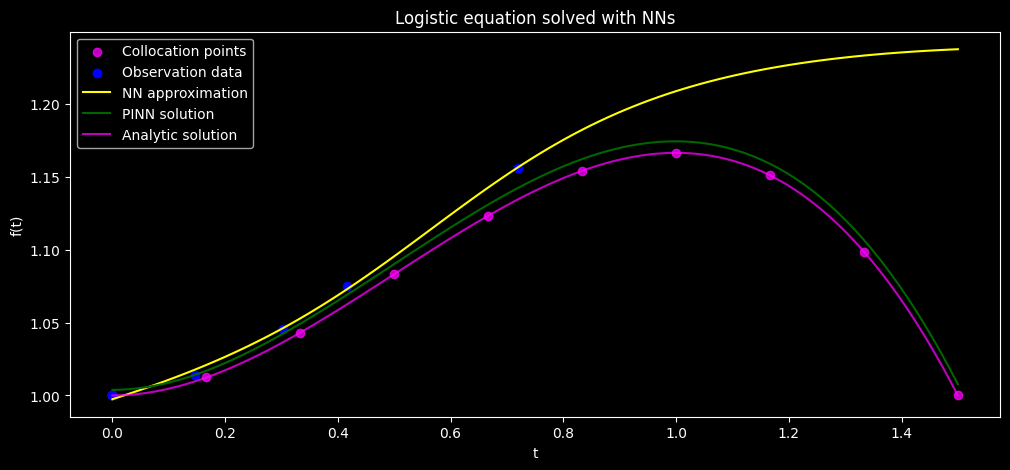

In [ ]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Observation data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="yellow")
ax.plot(x_eval.detach().numpy(), f_PINN_eval.detach().numpy(), label="PINN solution", color="darkgreen")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Analytic solution", color="magenta", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

### Example II: 1d wave

- Now, we want our NN to learn a function $f(x,t)$ that satisfies the following $2^\text{nd}$ order PDE:

$$\frac{\partial^2 f}{\partial x^2} = \frac{1}{C} \frac{\partial^2 f}{\partial t^2}$$

where $C$ is a positive constant.

- Differently from before, $f$ depends on two variables:
    - space ($x$),
    - time ($t$).
- We modify our neural network to accept to input variables.

In [73]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

- The function we defined before, `df()`, computes a derivatives of any order w.r.t. only one input variable.
- We need to modify it slightly to differentiate w.r.t. both $x$ and $t$.

In [74]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features
    using PyTorch autograd engine"""

    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

In [75]:
def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""

    f_value = model(x, t)
    return df(f_value, t, order=order) # <--- derivative wrt t

In [76]:
def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""

    f_value = model(x, t)
    return df(f_value, x, order=order) # <--- derivative wrt x

#### Loss definition

- For this example, we do not consider measurement data (but we could have done it).
- We train the NN with a loss that only accounts for physical equations.
- The first term of the loss encourages respecting the 1-dimensional wave equation:

$$\mathcal{L}_\text{PDE} = \left( \frac{\partial^2 f}{\partial x^2} - \frac{1}{C} \frac{\partial^2 f}{\partial t^2} \right)^2 $$

- As before, there are infinite solutions satisfying this equation.
- We need to restrict the possible solutions by:
    1. imposing periodic boundary conditions at the domain extrema.
    2. imposing an initial condition on $f(x, t_0)$.
    3. imposing an initial condition on $\frac{\partial f(x, t)}{\partial t} \bigg\rvert_{t=0}$.

- We define the domain of $x$ as $[x_0, x_1]$.
- In this example, $x_0 = 0$ and $x_1 = 1$, but they could be different values.

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/boundaries.png?raw=1" style="width: 40%; display: block; margin: auto;">

- The following loss penalizes the violation of the boundary conditions:

$$\mathcal{L}_\text{BC} = f(x_0, t)^2 + f(x_1, t)^2$$

- Next, we must define the initial condition on $f(x, t_0)$.

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/initial_cond.png?raw=1" style="width: 40%; display: block; margin: auto;">

- The following loss penalizes departure from the desired initial condition:

$$\mathcal{L}_\text{initF} = \left( f(x, t_0) - \frac{1}{2} \text{sin}(2\pi x) \right)^2 $$

- Finally, we must specify the initial condition on $\frac{\partial f(x, t)}{\partial t} \bigg\rvert_{t=0}$.

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/initial_cond2.jpeg?raw=1" style="width: 40%; display: block; margin: auto;">

The following loss penalizes departure from the desired initial condition of the 1st order derivative:

$$\mathcal{L}_\text{initDF} = \left( \frac{\partial f}{\partial t} \bigg\rvert_{t=0} \right)^2 $$

The total loss is given by:

$$\mathcal{L}_\text{PDE} + \mathcal{L}_\text{BC} + \mathcal{L}_\text{initF} + \mathcal{L}_\text{initDF}$$

In [77]:
def initial_condition(x) -> torch.Tensor:
    res = torch.sin( 2*np.pi * x).reshape(-1, 1) * 0.5
    return res

In [78]:
def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None,
    t_idx: torch.Tensor = None,
    C: float = 1.0,
    device: str = None) -> torch.float:

    # PDE
    pde_loss = dfdx(model, x, t, order=2) - (1/C**2) * dfdt(model, x, t, order=2)

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    boundary_loss_x1 = model(boundary_x1, t_idx)                                    # f(x1, t)

    # initial conditions
    f_initial = initial_condition(x_idx)                         # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_idx)                          # t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_idx, t_initial) - f_initial         # L_initF
    initial_loss_df = dfdt(model, x_idx, t_initial, order=1)     # L_initDF

    # obtain the final  loss by averaging each term and summing them up
    final_loss = pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        initial_loss_df.pow(2).mean()

    return final_loss

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

In [80]:
# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(3000):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.136011
epoch: 300, loss: 0.068945
epoch: 600, loss: 0.028567
epoch: 900, loss: 0.042533
epoch: 1200, loss: 0.027169
epoch: 1500, loss: 0.003901
epoch: 1800, loss: 0.001961
epoch: 2100, loss: 0.011300
epoch: 2400, loss: 0.000933
epoch: 2700, loss: 0.005212


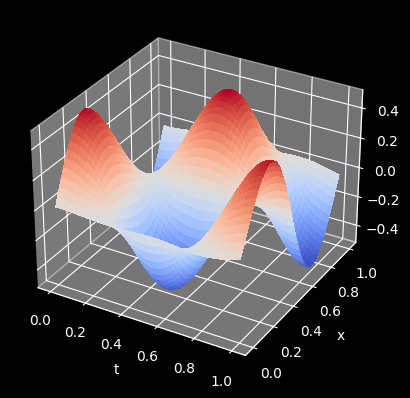

In [81]:
# Prediction
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show();

## Conclusions

**Example 1: Growth rate with Logistic Equation**

- We saw the difference between:
    - Fitting a NN only on observations.
    - Adding a regularization term from a 1st order PDE.

**Example 2: 1d wave**

- We saw how to include:
    - A 2nd order PDE.
    - Multiple constraints on the initial conditions.

**Next steps**

- With more complex equations, convergence is not achieved so easily.
- For time-dependent problems, many useful tricks have been devised over the past years such as:
    - Decomposing the solution domain in different parts solved using different neural networks.
    - Smart weighting of different loss contributions to avoid converging to trivial solutions.

## 📚 References

[[1](https://www.sciencedirect.com/science/article/pii/S0021999118307125)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational physics 378 (2019): 686-707.

[[2](https://maziarraissi.github.io/PINNs/)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics Informed Deep Learning".

[[3](https://www.sciencedirect.com/science/article/pii/S095219762030292X)] Nascimento, R. G., Fricke, K., & Viana, F. A. (2020). A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network. Engineering Applications of Artificial Intelligence, 96, 103996.

[[4](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4)] Dagrada, Dario. "Introduction to Physics-informed Neural Networks" ([code](https://github.com/madagra/basic-pinn)).

[[5](https://towardsdatascience.com/physics-and-artificial-intelligence-introduction-to-physics-informed-neural-networks-24548438f2d5)] Paialunga Piero. "Physics and Artificial Intelligence: Introduction to Physics Informed Neural Networks".

[[6](https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks)] "Physics-Informed-Neural-Networks (PINNs)" - implementation of PINNs in TensorFlow 2 and PyTorch for the Burgers' and Helmholtz PDE.